# Исследование закономерностей, определяющих успешность игр

## Изучение данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
from math import factorial
from scipy import stats as st
import numpy as np

In [2]:
data = pd.read_csv('/datasets/games.csv')

In [3]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
data.isnull().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В нашем распоряжении 16715 наблюдений. 

Видим, что в преобразовании нуждаются названия столбцов и их текстовое содержимое, а также типы данных (например, нужно привести значения столбца с годом выхода игры к целочисленному типу). 
В шести столбцах из 11 обнаружены пропуски. В трех из них пропусков незначительное количество - вероятно, мы просто удалим строки с этими пропусками. Сложнее ситуация со столбцами Critic_Score, User_Score, Rating: пропусков в них много, и нам придется чем-то их заполнить. 
Дубликатов на данном этапе не обнаружено.

## Предобработка данных

In [6]:
# приводим к нижнему регистру названия столбцов
data.columns = [col.lower() for col in data.columns]

In [7]:
# приводим к нижнему регистру значения строкового формата
# делаем это с помощью цикла, которым проходимся по колонкам, где хранятся строки
# на всякий случай используем также метод str.strip()
columns = ['name', 'platform', 'genre', 'rating']

for column in columns:
    data[column] = data[column].str.lower().str.strip()

In [8]:
data.dropna(subset=['name', 'year_of_release', 'genre'], inplace=True)

In [9]:
data['year_of_release'] = data['year_of_release'].astype('int')

В столбцах, строки с пропусками в которых мы удалили, было мало пропусков. Их удаление или заполнение не повлияло бы на наши итоговые подсчеты, при этом заполнить их возможно было только вручную, изучая каждую отдельную игру. В остальных строках с пропусками ситуация иная: количество пропусков такое, что удаление строк с ними сильно повредит датасету. При этом их нельзя заполнить, например, медианой или средним значением, если речь идет об оценках критиков или пользователей. Дело в том, что такие оценки субъективны и случайны, и заполнение медианным или средним значением может сильно исказить результаты.

Посмотрим, какие значения содержатся в остальных столбцах с пропусками. Это столбцы с рейтингом и оценками, в одном из которых будет значение 'tbd'. **'tbd' означает 'to be determined'.** 

In [10]:
data['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

In [11]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [12]:
data['rating'].unique()

array(['e', nan, 'm', 't', 'e10+', 'k-a', 'ao', 'ec', 'rp'], dtype=object)

Нам кажется, что значение 'tbd' можно использовать как маркер для неопределенного рейтинга. Рейтинг мог остаться неопределенным по разным причинам: от ошибки выгрузки и сбора данных до непосредственного отсуствия информации о рейтинге в источнике. 

In [13]:
data['rating'] = data['rating'].fillna('tbd')

Причины пропусков в столбцах с оценками критиков и пользователей могут быть как технические (неверная выгрузка или сбор данных), так и связанные с недостаточным количеством данных для подсчета оценки. 

В столбце с пользовательской оценкой такое значение будет нам мешать. Предварительно заменим его на NaN: NaN можно использовать в арифметических операциях. 

In [14]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = np.nan

In [15]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', '8.8', '6.9', '9.4', '6.8', '6.1',
       '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6', '3.7',
       '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9', '3.1',
       '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3', '2.7',
       '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0', '1.6',
       '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2', '2.3',
       '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'], dtype=object)

Далее добавим суммарное количество продаж игры во всех регионах отдельным столбцом в наш датафрейм.

In [16]:
data['total_sales'] = data['na_sales'] + data['jp_sales'] + data['other_sales'] + data['other_sales']

In [17]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8,e,62.03
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,NaN,NaN,tbd,37.43
2,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,e,26.05
3,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8,e,24.79
4,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,NaN,NaN,tbd,23.49


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null int64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       7983 non-null float64
user_score         7463 non-null object
rating             16444 non-null object
total_sales        16444 non-null float64
dtypes: float64(6), int64(1), object(5)
memory usage: 1.6+ MB


In [19]:
data['user_score'] = data['user_score'].astype('float')

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null int64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       7983 non-null float64
user_score         7463 non-null float64
rating             16444 non-null object
total_sales        16444 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.6+ MB


In [21]:
data.duplicated().sum()

0

Дубликатов по-прежнему не обнаружено.

### Вывод

Мы привели к нижнему регистру названия столбцов и их содержимое, а также обработали пропущенные значения. Пропуски были удалены в столбцах, где их мало. Пропуски в столбце с рейтнгом мы заменили на значение 'tbd', а в столбце с оценкой пользователей это же неопределенное значение мы заменили на NaN. Мы не стали заполнять пропуски с пользоватльской оценкой и оценкой критиков, поскольку их заполнение медианой или средним сильно исказит итоговые значения и при этом не совсем правомерно: оценка является субъективным показателем. Мы оставили значения NaN в этих столбцах, поскольку NaN можно использовать в арифметических операциях. 

Кроме того, мы добавили в таблицу столбец с продажами во всех регионах. 

## Исследовательский анализ данных

In [22]:
data_year = data.groupby('year_of_release').agg({'name':'count'}).reset_index()
data_year.head()

,year_of_release,name
0,1980,9
1,1981,46
2,1982,36
3,1983,17
4,1984,14


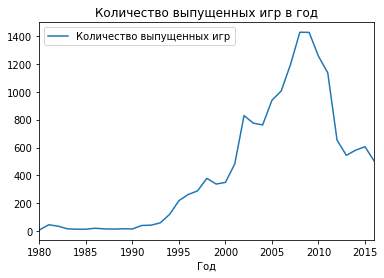

In [23]:
data_year.plot('year_of_release', 'name', label='Количество выпущенных игр')
plt.xlabel('Год')
plt.title('Количество выпущенных игр в год')
plt.legend()
plt.show()

Количество выпускамых игр в год сильно меняется с 1980 по 2015 год. Мы видим, что примерно с 1992 года количество выпускаемых игр в год начало сильно возрастать, достигнув пика в 2007 году и оставаясь практически неизменным с 2007 по 2009 год. С 2010 года есть тенденция к резкому падению количества выпускамых игр. Это может быть связано с тем, что особенно популярными становятся социальные сети, и фокус пользователя компьютера смещается со времени в играх на время в сети, а также с появлением смартфонов и развитием игр для мобильных устройств. 

Выделим 10 самых популярных пратформ и построим для них графики кривой. 

In [24]:
platform_sales_top10 = data.groupby('platform').agg({'total_sales':'sum'}).sort_values(by='total_sales', ascending=False).head(10)
platform_sales_top10

,total_sales
platform,
ps2,1091.40
x360,777.80
ps3,738.72
wii,710.57
ds,673.41
ps,555.88
psp,264.67
gba,245.90
nes,235.21


In [25]:
# сохраняем в список названия самых популярных платформ
platform_top10 = platform_sales_top10.index.tolist()
platform_top10

['ps2', 'x360', 'ps3', 'wii', 'ds', 'ps', 'psp', 'gba', 'nes', 'ps4']

In [26]:
# создаем датафрейм, который включает информацию только по самым популярным платформам
data_top = data.query('platform in @platform_top10')

In [27]:
# группируем его так, чтобы столбцы, по которым идет группировка, не становились индексами
data_top_grpd = data_top.groupby(['platform', 'year_of_release'],as_index=False).agg({'total_sales':'sum'})
data_top_grpd

,platform,year_of_release,total_sales
0,ds,1985,0.02
1,ds,2004,14.70
2,ds,2005,99.45
3,ds,2006,104.91
4,ds,2007,124.24
...,...,...,...
98,x360,2012,76.03
99,x360,2013,69.31
100,x360,2014,26.59
101,x360,2015,9.56


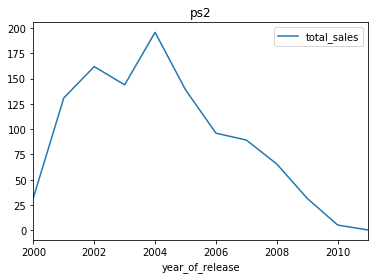

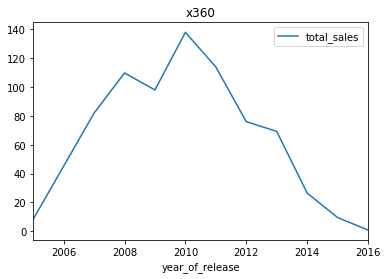

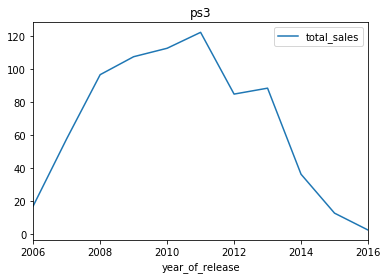

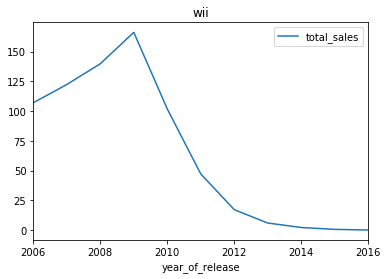

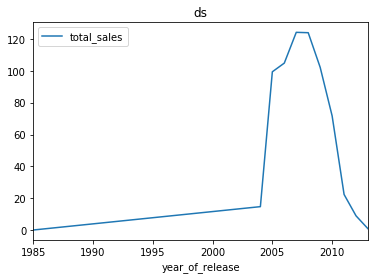

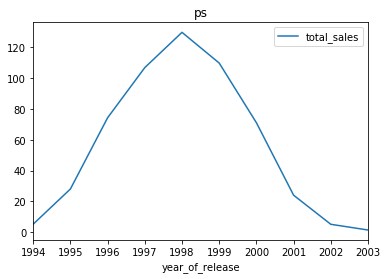

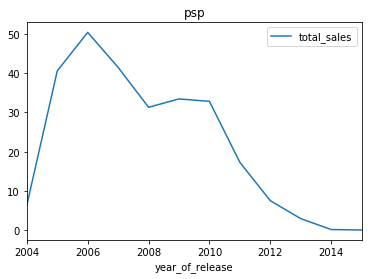

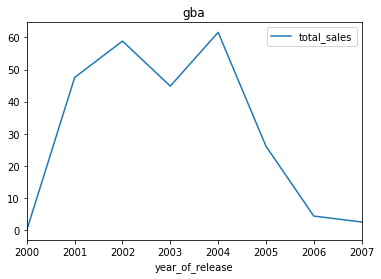

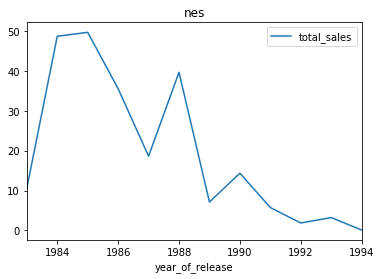

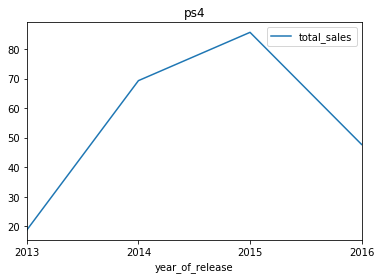

In [28]:
# циклом строим графики кривой для каждой платформы
for i in platform_top10: 
    df = data_top_grpd.loc[data_top_grpd['platform'] == i]
    df.plot('year_of_release', 'total_sales')
    if i == 'ps4':
        plt.xticks([2013, 2014, 2015, 2016])
    plt.title(i)
    plt.show()

Видим, как меняются продажи по разным платформам. Обычный "жизненный цикл" платформы - около 10 лет, однако есть платформы, которые "живут" дольше, например, ds или ps2, или меньше, например, gba. Очевидно, что продажи ps4 еще идут активно, а лет на графике так мало, потому что это самая "молодая" платформа.

**В качестве актуального периода будем рассматривать данные, начиная с 2010 года.**
Это связано как резким падением продаж игр и изменением технологий, так и тем, что, судя по "жизненному циклу" десяти наиболее популярных платформ, пик продаж оказывается приблизительно в середине их жизненного цикла. Учитывая скорость развития технологий, очень маловероятно, что в 2017 году популярной станет платформа старше 2010 года. 

In [29]:
actual = data.query('year_of_release >= 2010')
actual_platform = actual['platform'].unique().tolist()
actual_platform

['x360',
 'ps3',
 'ds',
 'ps4',
 '3ds',
 'wii',
 'xone',
 'wiiu',
 'pc',
 'psp',
 'psv',
 'ps2']

Посмотрим, что сейчас происходит с платформами, для которых выходят игры в актуальном периоде. 

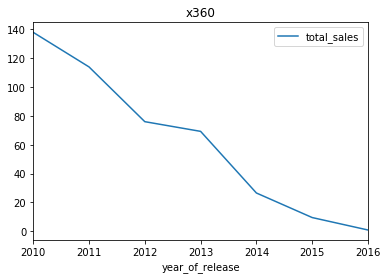

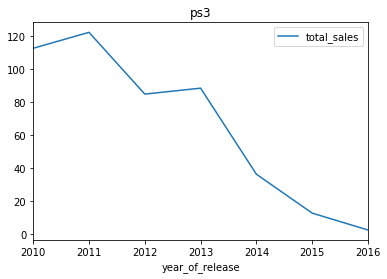

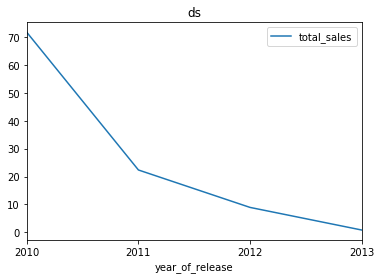

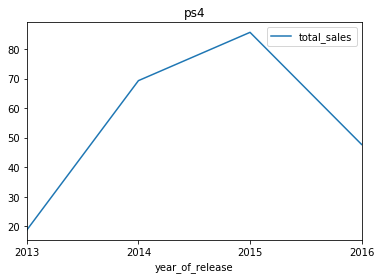

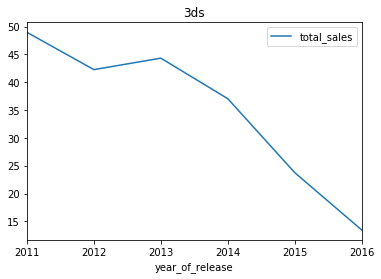

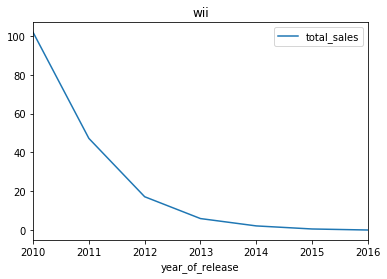

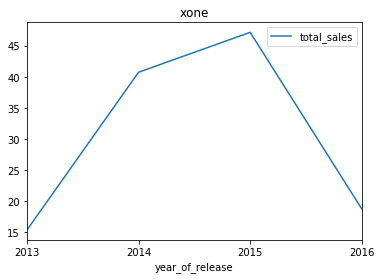

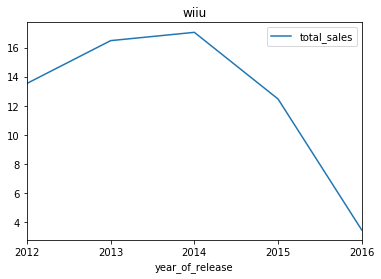

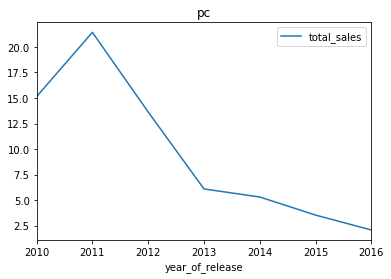

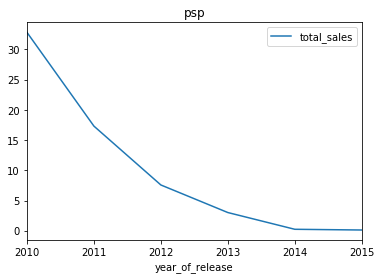

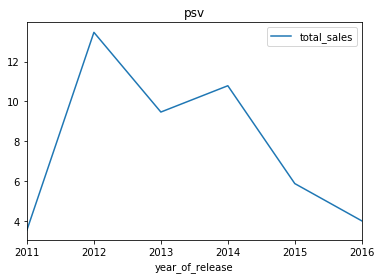

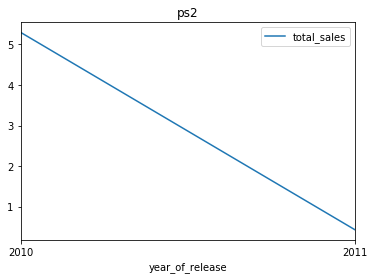

In [30]:
for i in actual_platform:
    df = actual.loc[actual['platform'] == i]
    df.groupby('year_of_release', as_index=False).agg({'total_sales':'sum'}).plot('year_of_release', 'total_sales')
    if i == 'wiiu':
        plt.xticks([2012, 2013, 2014, 2015, 2016])
    if i == 'xone':
        plt.xticks([2013, 2014, 2015, 2016])
    if i == 'ps2':
        plt.xticks([2010, 2011])
    if i == 'ps4':
        plt.xticks([2013, 2014, 2015, 2016])
    if i == 'ds':
        plt.xticks([2010, 2011, 2012, 2013])
    plt.title(i)
    plt.show()

Безусловный лидер сейчас - это ps4. Возможность роста есть у xone: мы видели, что чаще всего у игровой платформы несколько пиков, который могут быть связаны, например, с выходом новой игры для этой платформы. Кроме того, платформа достаточно молодая самая по себе и выпущена одним из действующих лидеров.  

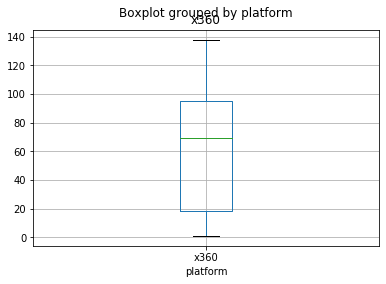

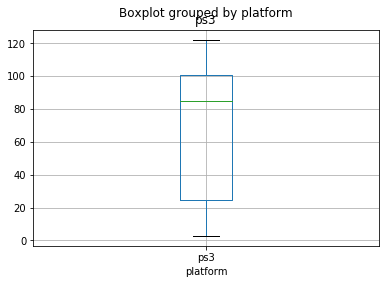

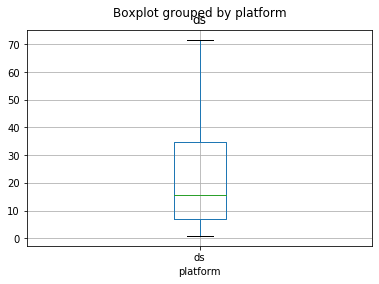

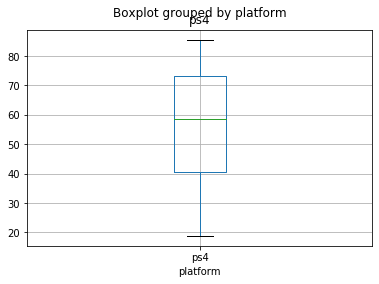

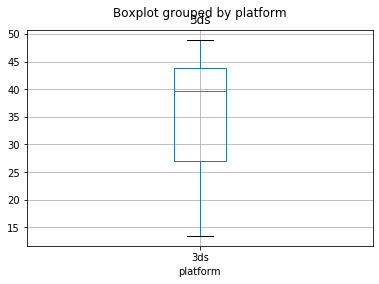

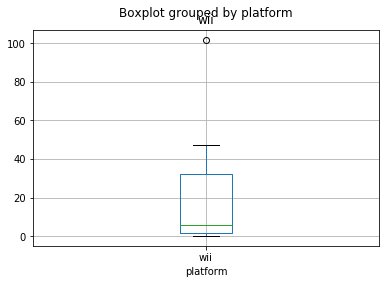

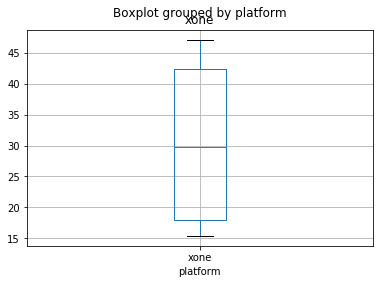

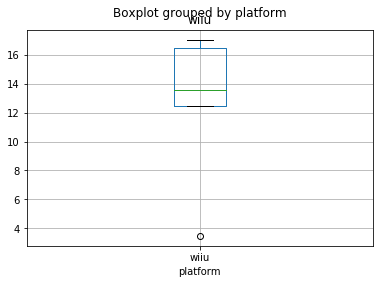

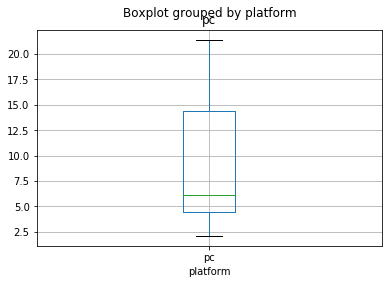

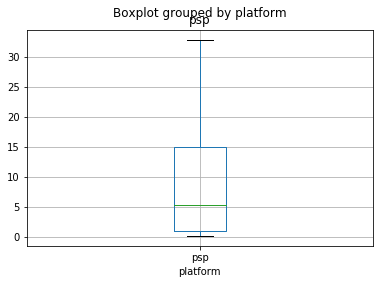

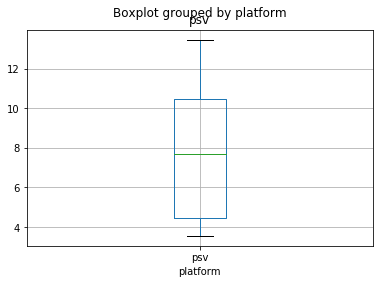

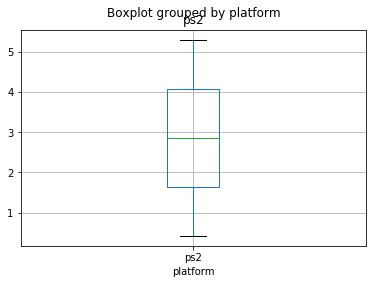

In [31]:
for i in actual_platform:
    df = actual.loc[actual['platform'] == i]
    df.groupby(['year_of_release', 'platform'], as_index=False).agg({'total_sales':'sum'}).boxplot('total_sales', by='platform')
    plt.title(i)
    plt.show()

За указанный период немногие платформы показывают высокую медиану продаж. Самая высокая она у ps3, далее следует x360. Эти платформы относятся к предыдущему поколению приставок и высокая медиана связана с удаленными на несколько лет пиками продаж. Хорошие медианные показатели у действующего лидера ps4, xone и ds4 (в случае последнего во многом за счет очень удачного старта продаж). *Можно сделать вывод, что наиболее удачным решением будет делать ставку на платформы производителей-лидеров: sony, microsoft, nintendo.* 

Разберем данные по ps4. 

In [32]:
data_ps4 = actual.query('platform == "ps4"')
data_ps4.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,call of duty: black ops 3,ps4,2015,shooter,6.03,5.86,0.36,2.38,NaN,NaN,tbd,11.15
42,grand theft auto v,ps4,2014,action,3.96,6.31,0.38,1.97,97.0,8.3,m,8.28
77,fifa 16,ps4,2015,sports,1.12,6.12,0.06,1.28,82.0,4.3,e,3.74
87,star wars battlefront (2015),ps4,2015,shooter,2.99,3.49,0.22,1.28,NaN,NaN,tbd,5.77
92,call of duty: advanced warfare,ps4,2014,shooter,2.81,3.48,0.14,1.23,83.0,5.7,m,5.41


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f77a4c39410>,
      dtype=object)

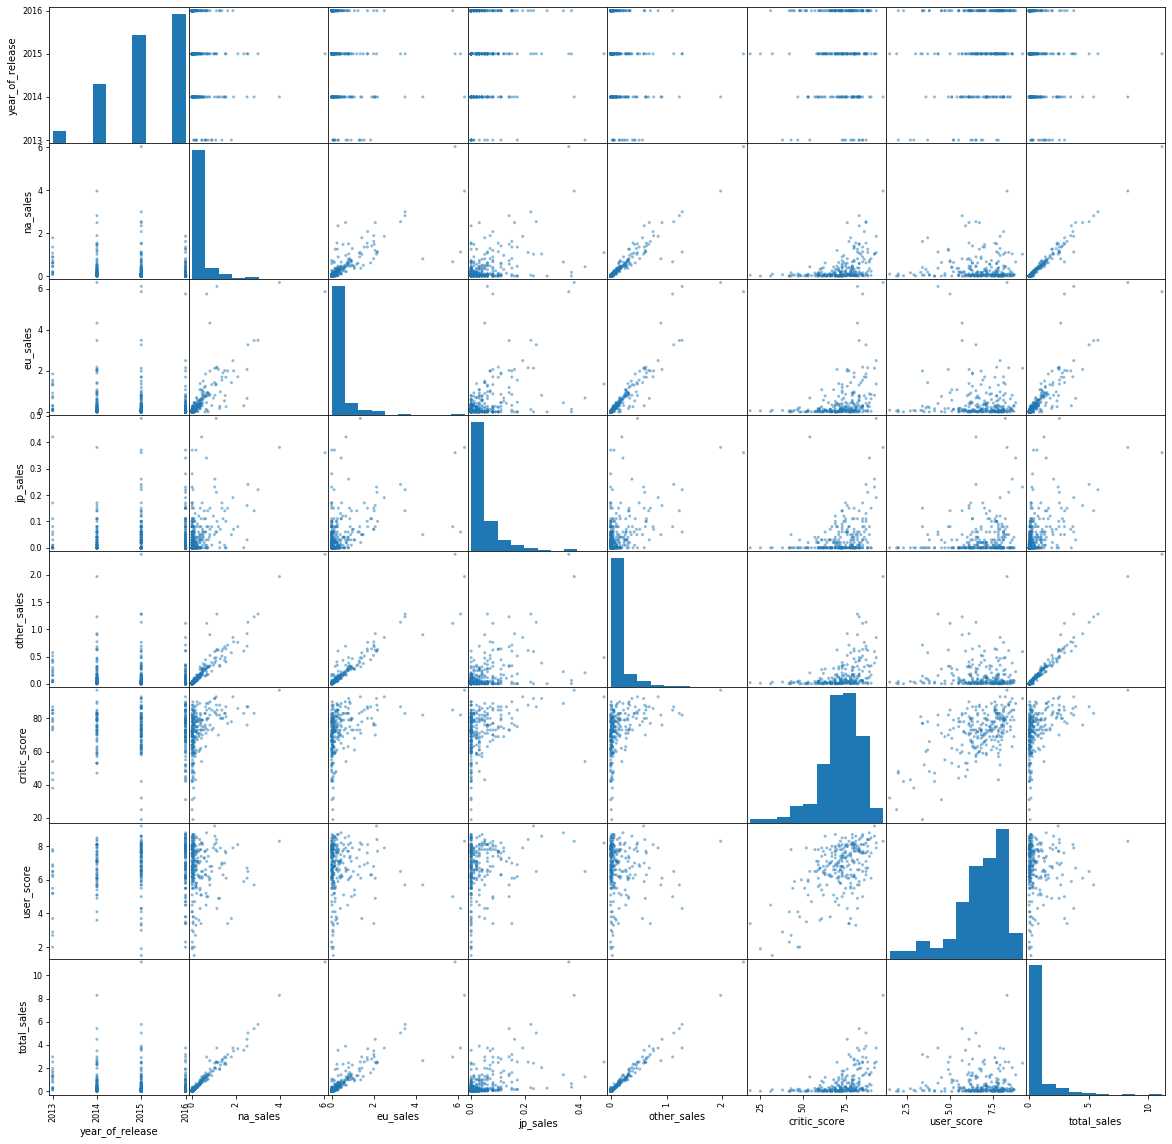

In [33]:
pd.plotting.scatter_matrix(data_ps4, figsize=(20,20))

In [34]:
data_ps4.corr()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
year_of_release,1.000000,-0.248961,-0.208306,-0.060993,-0.234796,-0.021142,0.152447,-0.241732
na_sales,-0.248961,1.000000,0.785362,0.472981,0.944259,0.415008,-0.020933,0.985638
eu_sales,-0.208306,0.785362,1.000000,0.464563,0.944698,0.346720,-0.048925,0.872813
jp_sales,-0.060993,0.472981,0.464563,1.000000,0.496467,0.322358,0.171332,0.537170
other_sales,-0.234796,0.944259,0.944698,0.496467,1.000000,0.409191,-0.035639,0.983388
critic_score,-0.021142,0.415008,0.346720,0.322358,0.409191,1.000000,0.557654,0.426000
user_score,0.152447,-0.020933,-0.048925,0.171332,-0.035639,0.557654,1.000000,-0.016853
total_sales,-0.241732,0.985638,0.872813,0.537170,0.983388,0.426000,-0.016853,1.000000


Высокая положительная прямая зависимость наблюдается только по продажам в Северной Америке, Европе и других регионах, при этом на продажи в Японии ориентироваться нельзя: корреляция тут на уровне средней, японский рынок отличается от всех остальных. Высокой прямой зависимости между оценками критиков или пользователей и продажами не наблюдается: возможно, люди приобретают игры до появления обзоров, ориентируются на маркетинговые материалы и "прогрев" продаж, который происходит перед запуском всех значимых игр. *Вероятно, то же самое мы сможем сказать и о других платформах: люди, интересующиеся играми, вероятно, приобретают ожидаемую новинку независимо от обзоров.* 

In [35]:
gen_sum_sorted = actual.groupby('genre', as_index=False).agg({'total_sales':['sum','count','median']}).sort_values([('total_sales', 'sum')], ascending=False)
gen_sum_sorted

genre total_sales             
                         sum count median
0         action      516.08  1495  0.120
8        shooter      365.07   410  0.275
7   role-playing      264.01   568  0.135
10        sports      250.78   575  0.170
3           misc      188.85   576  0.110
4       platform       92.13   153  0.170
6         racing       83.07   237  0.110
2       fighting       69.57   199  0.150
9     simulation       51.03   217  0.080
1      adventure       47.73   563  0.030
11      strategy       26.65   170  0.070
5         puzzle       15.54   114  0.050

In [36]:
gen_median_sorted = actual.groupby(
    'genre', as_index=False).agg(
    {'total_sales':['sum','count','median']}).sort_values(
    [('total_sales', 'median')], ascending=False)

gen_median_sorted

genre total_sales             
                         sum count median
8        shooter      365.07   410  0.275
4       platform       92.13   153  0.170
10        sports      250.78   575  0.170
2       fighting       69.57   199  0.150
7   role-playing      264.01   568  0.135
0         action      516.08  1495  0.120
3           misc      188.85   576  0.110
6         racing       83.07   237  0.110
9     simulation       51.03   217  0.080
11      strategy       26.65   170  0.070
5         puzzle       15.54   114  0.050
1      adventure       47.73   563  0.030

По сумме продаж выделяются 5 жанров-лидеров: экшен, шутер, ролевая игра и спорт, а также жанр "прочее". Меньше всего люди любят пазлы и стратегии. Кажется, что зависимость здесь большая, чем с оценками критиков или пользователей. 

Медианные продажи дают другую картинку: самая высокая медиана продаж у шутеров, далее идею платформеры и игры в жанре "спорт", файтинги и ролевые игры. Жанр "экшен", занявший первое место по сумме продаж и их количеству, в пятерку лидеров не вошел. Это может говорить о том, что есть большая доля рынка, на которой иные предпочтения по жанрам игр.

### Вывод

Нам не удалось обнаружить прямой зависимости между оценками критиков и пользователей и уровнем продаж. Продажи в Северной Америке, Европе и других регионах коррелируют друг с другом высоко, корреляция положительная, а вот Японский рынок от них отличается. 

Среди жарнов лучше всего продается жанр экшен, а хуже всего - пазл. Экшен продается примерно в 33 раза лучше. 

## Портрет пользователей в разных регионах

In [37]:
sales_reg = actual.groupby('platform').agg({'eu_sales':'sum', 'na_sales':'sum', 'jp_sales':'sum'})
sales_reg

,eu_sales,na_sales,jp_sales
platform,,,
3ds,61.27,82.65,100.62
ds,28.06,59.66,27.90
pc,68.82,39.07,0.00
ps2,1.67,2.32,0.80
ps3,213.60,229.25,59.26
ps4,141.09,108.74,15.96
psp,7.59,9.65,42.20
psv,13.07,12.47,21.84
wii,65.91,121.20,17.75


In [38]:
def pie_func(data, sortby, title):
    data.sort_values(by=sortby, ascending=False).head().plot(kind='pie',y=sortby, autopct='%1.1f%%')
    plt.title(title)
    plt.show()

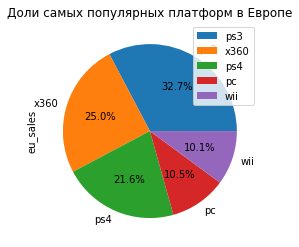

In [39]:
pie_func(sales_reg, 'eu_sales', 'Доли самых популярных платформ в Европе')

Самые популярные платформы в Европе: PS3, X360, PS4, WII, PC. Среди них лидер - PS3.

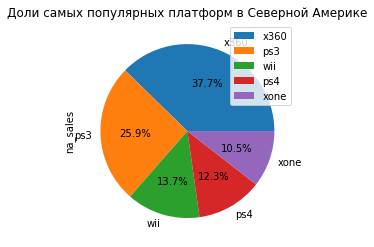

In [40]:
pie_func(sales_reg, 'na_sales', 'Доли самых популярных платформ в Северной Америке')

Лидер в Северной Америке - X360. Далее идут PS3, WII, PS4, XONE.

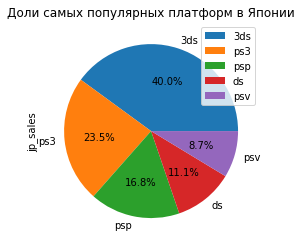

In [41]:
pie_func(sales_reg, 'jp_sales', 'Доли самых популярных платформ в Японии')

Видим, что особенно сильно отличается японский рынок. Среди популярных платформ отсуствуют платформы от Microsoft: Японцы выбирают Nintendo и Sony, то есть именно японским компаниям принадлежит японский рынок. **Планируя рекламную кампанию в Японии следует делать упор на платформы от Nintendo и Sony.**

In [42]:
genres_reg = actual.groupby('genre').agg({'eu_sales':'sum', 'na_sales':'sum', 'jp_sales':'sum'})
genres_reg

,eu_sales,na_sales,jp_sales
genre,,,
action,233.63,290.64,72.20
adventure,18.88,20.84,15.67
fighting,20.33,39.05,13.90
misc,66.09,123.80,24.29
platform,38.30,54.90,15.81
puzzle,6.58,9.10,3.40
racing,54.75,46.11,6.68
role-playing,75.48,112.05,103.54
shooter,171.45,237.47,14.04


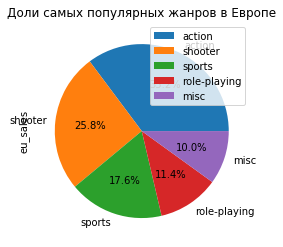

In [43]:
pie_func(genres_reg, 'eu_sales', 'Доли самых популярных жанров в Европе')

Самые популярные жанры в Европе совпадают с теми, что мы выделили по всей выборке. Это экшен, шутер, ролевая игра и спорт, а также жанр "прочее". Самый популярный жанр - экшен, он лидирует и по всей выборке. 

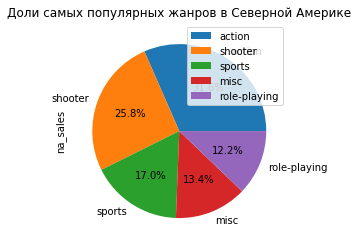

In [44]:
pie_func(genres_reg, 'na_sales', 'Доли самых популярных жанров в Северной Америке')

Ситуация в Америке почти повторяет ситуацию в Европе и снова совпадает с ситуацией по всей выборке.

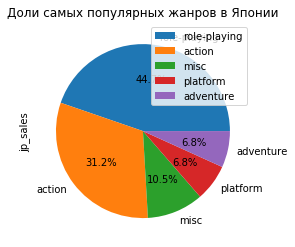

In [45]:
pie_func(genres_reg, 'jp_sales', 'Доли самых популярных жанров в Японии')

В Японии свой топ-5 популярных жанров: ролевая игра оказывается на первом месте, опередив даже экшен, а за жанром "прочее" идут платформеры и приключения, которых не было в пятерке лидеров ни по всей выборке, ни в Северной Америке или Европе. **Планируя рекламные кампании в Северной Америке и Европе можно ориентироваться на общемировые тенденции, однако рынок в Японии очень отличается и там другие жанровые предпочтения.**

In [46]:
rating_reg = actual.groupby('rating').agg({'eu_sales':'sum', 'na_sales':'sum', 'jp_sales':'sum'})
rating_reg

,eu_sales,na_sales,jp_sales
rating,,,
e,197.34,271.15,47.87
e10+,99.28,159.38,13.22
ec,0.00,1.13,0.00
m,292.04,382.22,30.45
rp,0.03,0.00,0.00
t,113.08,160.81,42.11
tbd,139.44,155.72,171.49


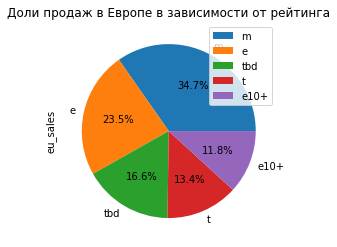

In [47]:
pie_func(rating_reg, 'eu_sales', 'Доли продаж в Европе в зависимости от рейтинга')

В Европе популярнее всего игры для взрослых, для всех, для подростков, а также для детей старше 10 лет. В топе-5 также игры с неопределенным рейтингом. 

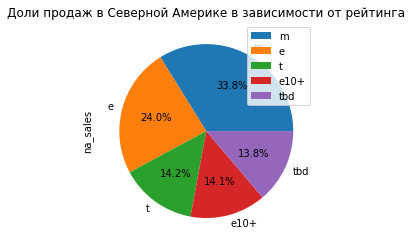

In [48]:
pie_func(rating_reg, 'na_sales', 'Доли продаж в Северной Америке в зависимости от рейтинга')

В Северной Америке ситуация почти полностью копирует европейскую, топ-5 не меняется. 

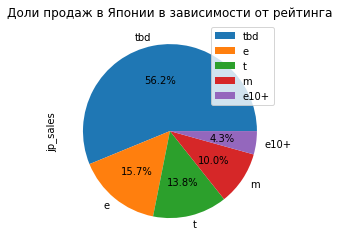

In [49]:
pie_func(rating_reg, 'jp_sales', 'Доли продаж в Японии в зависимости от рейтинга')

В Японии сильно меняется распределение долей. Больше всего покупают игры с неизвестным рейтигом, а вот игры для взрослых, наиболее популярные в Северной Америке и Европе, оказываются на 4 месте. 

### Вывод

Планируя рекламные кампании в Северной Америке и Европе можно ориентироваться на общемировые тенденции в жанрах, рейтингах и платформах. Выходя на японский рынок, нужно подстраивать рекламные кампании под него: он очень от американского и европейского по всем изученным параметрам. 

## Проверка статистических гипотез

### Гипотеза о платформах

**Нулевая гипотеза:** Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

**Альтернативная гипотеза:** Средние пользовательские рейтинги платформ Xbox One и PC разные.

In [50]:
xone_rating = actual.query('platform == "xone" and user_score != "NaN"')['user_score']
pc_rating = actual.query('platform == "pc" and user_score != "NaN"')['user_score']

In [51]:
print('Средний пользовательский рейтинг Xbox One', xone_rating.mean())
print('Средний пользовательский рейтинг PC', pc_rating.mean())

Средний пользовательский рейтинг Xbox One 6.521428571428572
Средний пользовательский рейтинг PC 6.5181818181818185


Видим, что разница минимальна. Проверим это. Сначала сравним дисперсии. *Сравнение дисперсий нужно нам, чтобы понять, какое значение задать параметру equal_var в st.ttest_ind(). Данный параметр означает "равная дисперсия". Его дефолтное значение - True, и мы сохраняем его тогда, когда есть основания полагать, что выборки взяты из общих по параметрам совокупностей. Если дисперсии будут сильно отличаться друг от друга, нужно будет указать параметр equal_var=False.*

In [52]:
print('Дисперсия для массива по Xbox One', np.var(xone_rating, ddof=1))
print('Дисперсия для массива по PC', np.var(pc_rating, ddof=1))

Дисперсия для массива по Xbox One 1.9069968429360695
Дисперсия для массива по PC 2.450446015110894


Проверим, можно ли отвергнуть нулевую гипотезу.

In [53]:
result1 = st.ttest_ind(xone_rating, pc_rating)
p_value1 = result1.pvalue

alpha = 0.05

#print(p_value1)

if p_value1 < alpha:
    print('Нулевую гипотезу можно отвергнуть')
else:
    print('Нулевую гипотезу нельзя отвергнуть')

Нулевую гипотезу нельзя отвергнуть


#### Вывод

Нельзя отвергнуть нулевую гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

### Гипотеза о жанрах

**Нулевая гипотеза:** Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые.

**Альтернативная гипотеза:** Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

In [54]:
action_rating = actual.query('genre == "action" and user_score != "NaN"')['user_score']
sports_rating = actual.query('genre == "sports" and user_score != "NaN"')['user_score']

In [55]:
print('Средний пользовательский рейтинг жанра Action', action_rating.mean())
print('Средний пользовательский рейтинг жанра Sports', sports_rating.mean())

Средний пользовательский рейтинг жанра Action 6.781899871630296
Средний пользовательский рейтинг жанра Sports 5.901587301587302


Видим, что разница минимальна. Проверим это. Сначала сравним дисперсии. 

In [56]:
print('Дисперсия для массива по жанру Action', np.var(action_rating, ddof=1))
print('Дисперсия для массива по жанру Sports', np.var(sports_rating, ddof=1))

Дисперсия для массива по жанру Action 1.8501475426606517
Дисперсия для массива по жанру Sports 2.8356344151248614


Проверим, можно ли отвергнуть нулевую гипотезу.

In [57]:
result2 = st.ttest_ind(action_rating, sports_rating)
p_value2 = result2.pvalue

#print(p_value2)

alpha = 0.05

if p_value2 < alpha:
    print('Нулевую гипотезу можно отвергнуть')
else:
    print('Нулевую гипотезу нельзя отвергнуть')

Нулевую гипотезу можно отвергнуть


#### Вывод

Можно отвергнуть нулевую гипотезу о том, что средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые.

## Общий вывод

При планировании рекламной кампании необходимо учитывать региональные особенности рынка, и это очень ярко проявляется в Японии, где отдельные предпочтения по жанрам, рейтингам и платформам. Во всех остальных регионах нужно делать ставку на основных производителей платформ (Sony, Microsoft), молодые платформы, жанры экшен, шутер, ролевая игра и спорт, а также жанр "прочее". Прямой зависимости продаж от рейтинга пользователей и зрителей обнаружено не было: кажется, люди ориентируются на любимые жанры, платформы и рекламные материалы разработчиков больше, а также, вероятно, предпочитают покупать игры максимально близко к дате их выхода. 